# Activity Recognition with Healthy Older People Using a Batteryless Wearable Sensor

This notebook provides code for loading the [activity recognition dataset](https://archive.ics.uci.edu/dataset/427/activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor) into a suitable format for classification and sequence labelling. 

The code is divided into three sections:
* Loading the data
* Sequence labelling: processing the data into a suitable format for sequence labelling. 
* Classification: processing the data into a suitable format for use with an IID classifier.

We recommend running all three sections, then using the variables produced by the code as required for sequence labelling and IID classification.


## Loading the Data

Run the following cells to load the data from disk. You will need to run code from the subsequent sections (or your own code) to get the data into a suitable format for classification and sequence labelling.  

In [135]:
import os

data_path = "activity_recognition_dataset/S1_Dataset"

files = os.listdir(data_path)
print(files)

['d1p01M', 'd1p02M', 'd1p03M', 'd1p04M', 'd1p05M', 'd1p06M', 'd1p07M', 'd1p08F', 'd1p09F', 'd1p10F', 'd1p11F', 'd1p12F', 'd1p13F', 'd1p14F', 'd1p15F', 'd1p16F', 'd1p17F', 'd1p18F', 'd1p19F', 'd1p20F', 'd1p21F', 'd1p22F', 'd1p23F', 'd1p24F', 'd1p25F', 'd1p26F', 'd1p27F', 'd1p28F', 'd1p29F', 'd1p30F', 'd1p31F', 'd1p32F', 'd1p33F', 'd1p34F', 'd1p35F', 'd1p36M', 'd1p37M', 'd1p38M', 'd1p39M', 'd1p40M', 'd1p41M', 'd1p42M', 'd1p43M', 'd1p44M', 'd1p45M', 'd1p46M', 'd1p47M', 'd1p48M', 'd1p49F', 'd1p50F', 'd1p51F', 'd1p52F', 'd1p53F', 'd1p54F', 'd1p55F', 'd1p56F', 'd1p57F', 'd1p58F', 'd1p59F', 'd1p60F', 'README.txt']


In [136]:
import pandas as pd  # use pandas to load data from CSV files

combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

## Sequence Labelling

The following cell creates two variables that you can use for sequence labelling:
* X_by_seq is a list of 2-D numpy arrays. Each numpy array in this list corresponds to on data sequence and contains the input feature values for that sequence.
* y_by_seq is a list of 1-D numpy arrays, where each array contains the target class labels for each sequence. 

In [137]:
import numpy as np

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?

### Variables for sequence labelling

The cell below produces the data you need for sequence labelling... You should be able to work with these variables directly.

In [138]:
from sklearn.model_selection import train_test_split

# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  # You may wish to make further splits of the data or to modify this split.

You may find the following code useful for creating a sequence labelling model:

In [139]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label

for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])

In [140]:
from hmmlearn import hmm  # We recommend using this class if builing an HMM

# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)

## IID Classification

In this code, we take the X and y lists produced for sequence labelling, and concatenate the data points for all sequences. This produces a single set of training data and a single set of test data, which are not divided into separate sequences.  

In [141]:
X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier

In [142]:
X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier

In [143]:
print(X_tr.shape, y_tr.shape, X_test.shape, y_test.shape)
print("2d array of features for training:      46509 elements of size 6" )
print("2d array of target labels for training: 46509 elements of size 0" )
print("2d array of features for testing:       5973 elements of size 6" )
print("2d array of target labels for training: 5973 elements of size 0" )
print(X_tr[0], y_tr[0])

(46509, 6) (46509,) (5973, 6) (5973,)
2d array of features for training:      46509 elements of size 6
2d array of target labels for training: 46509 elements of size 0
2d array of features for testing:       5973 elements of size 6
2d array of target labels for training: 5973 elements of size 0
[ 3.8928e-01  9.5081e-01  7.7541e-02 -5.6000e+01  3.7874e+00  9.2225e+02] 3


In [144]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import graphviz

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [145]:
model = DecisionTreeClassifier()
model.fit(X_tr, y_tr)

DecisionTreeClassifier()

In [146]:
print("Accuracy on training set: {:.3f}".format(model.score(X_tr, y_tr)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.841


In [165]:
# Bagging ensemble of decision trees
num_models = 20
sample_size = 2000  # training set size.
np.random.seed(0)

all_models = []
for m in range(num_models):
    # Sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    # Hint: look at the documentation for numpy.random.choice().
    sample_idx = np.random.choice(X_tr.shape[0], sample_size)
    X_train_sample, y_train_sample = X_tr[sample_idx], y_tr[sample_idx]
    
    model = DecisionTreeClassifier()
    
    # train a decision tree classifier on the random sample.
    model.fit(X_train_sample,y_train_sample)
    
    all_models.append(model)

In [166]:
# Implement bagging prediction 
# count how many classifiers have voted for each class for each point in the test dataset.
def bagging_predict(test_data, all_models):
    votes = np.zeros((test_data.shape[0], len(all_models)))  # number of classes = 10.
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
        # TODO
        # obtain the predictions from model m for the test data and
        # populate the votes vector
        votes[:, idx] = m.predict(test_data)
        
    for test_point in range(votes.shape[0]):
        # TODO
        # determine the class with the most votes for each test point
        # and populate the combined_predictions 
        # hint use np.bincount
        combined_predictions[test_point] = np.bincount(int64(votes[test_point])).argmax()
    
    return combined_predictions

In [167]:
prediction = bagging_predict(X_test, all_models)
accuracy = np.count_nonzero(prediction==int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))

Test set accuracy: 0.8982086053909258


In [168]:
# Random Forest Training
num_models = 20
sample_size = 2000  # training set size.
feature_sample_size = 200
np.random.seed(0)

all_models = []
all_selected_features = []  # for each model, save the list of selected feature indexes.
for m in range(num_models):
    # TODO
    # copy in your code from the bagging exercise here to sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    # Hint: look at the documentation for numpy.random.choice().
    sample_idx = np.random.choice(X_tr.shape[0], sample_size)
    X_tr_sample, y_train_sample = X_tr[sample_idx], y_tr[sample_idx]

    # TODO
    # create a decision tree classifier with limited features considered
    # for each split
    model = DecisionTreeClassifier(max_features=feature_sample_size)
    
    # TODO
    # copy in your code from the bagging exercise here to train a decision tree classifier on the random sample.
    # Remember to train it only on the random sample of features.
    model.fit(X_tr_sample, y_train_sample)
    
    all_models.append(model)

In [172]:
prediction = bagging_predict(X_test, all_models)
print(prediction)
accuracy = np.count_nonzero(prediction==int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))

[1. 0. 2. ... 2. 2. 2.]
Test set accuracy: 0.8982086053909258


c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning:

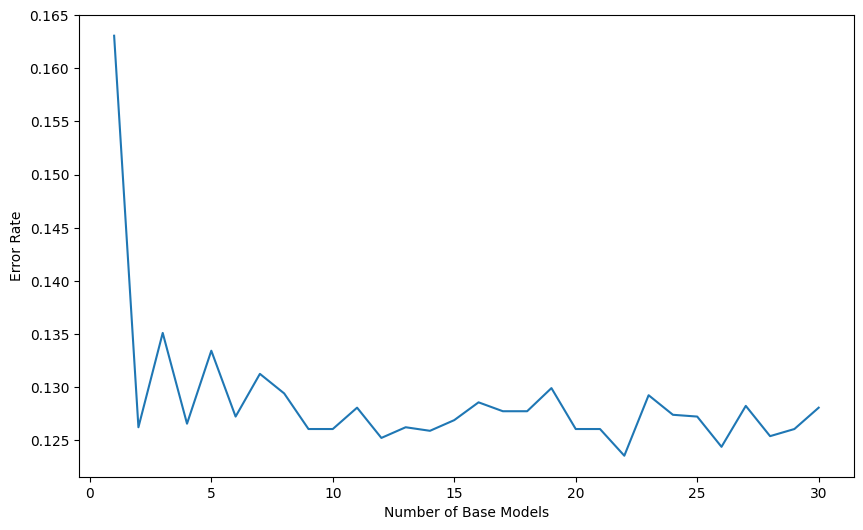

In [268]:
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import BaggingClassifier

# Initialize an empty list to store error rates
error_rates = []

# Range of 'n_estimators' values to explore
model_range = range(1, 31)

for n_models in model_range:
    # Train Bagging classifier
    bagging_clf = BaggingClassifier(
        base_estimator=DecisionTreeClassifier(),
        n_estimators=n_models,
        random_state=42
    ).fit(X_tr, y_tr)

    # Predict on test set
    y_pred = bagging_clf.predict(X_test)

    # Calculate error rate
    error_rate = zero_one_loss(y_test, y_pred)

    # Append error rate to list
    error_rates.append(error_rate)

# Plot error rates
plt.figure(figsize=(10, 6))
plt.plot(model_range, error_rates)
plt.xlabel('Number of Base Models')
plt.ylabel('Error Rate')
# plt.title('Error Rate vs. Number of Base Models in Bagging')
# plt.grid(True)
plt.show()

In [224]:
num_models = 20
sample_size = 2000  # training set size.
np.random.seed(0)

all_models = []
for m in range(num_models):
    # TODO
    # Sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    # Hint: look at the documentation for numpy.random.choice().
    sample_idx = np.random.choice(X_tr.shape[0], sample_size)
    X_train_sample, y_train_sample = X_tr[sample_idx], y_tr[sample_idx]
    
    model = DecisionTreeClassifier()
    
    # TODO
    # train a decision tree classifier on the random sample.
    model.fit(X_train_sample,y_train_sample)
    
    all_models.append(model)

In [225]:
# count how many classifiers have voted for each class for each point in the test dataset.
def bagging_predict(test_data, all_models):
    votes = np.zeros((test_data.shape[0], len(all_models)))  # number of classes = 10.
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
        # TODO
        # obtain the predictions from model m for the test data and
        # populate the votes vector
        votes[:, idx] = m.predict(test_data)
        
    for test_point in range(votes.shape[0]):
        # TODO
        # determine the class with the most votes for each test point
        # and populate the combined_predictions 
        # hint use np.bincount
        combined_predictions[test_point] = np.bincount(int64(votes[test_point])).argmax()
    
    return combined_predictions

In [473]:
prediction = bagging_predict(X_test, all_models)
accuracy = np.count_nonzero(prediction==int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))

Test set accuracy: 0.8982086053909258


In [481]:
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import BaggingClassifier

error_rates = []
base_error_rates = []
num_models = range(1, 41)
print(models_ranges)

for n_models in num_models:
        bagging_clf = BaggingClassifier(
            base_estimator=DecisionTreeClassifier(),
            n_estimators=n_models
        ).fit(X_tr, y_tr)

        y_pred = bagging_clf.predict(X_test)
        error_rate = zero_one_loss(y_test, y_pred)
        error_rates.append(error_rate)

for n_models in num_models:
    base_model = DecisionTreeClassifier()
    base_model.fit(X_tr, y_tr)

    y_pred = base_model.predict(X_test)
    error_rate = zero_one_loss(y_test, y_pred)
    base_error_rates.append(error_rate)

[range(1, 20), range(1, 30), range(1, 40), range(1, 50)]


c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning:

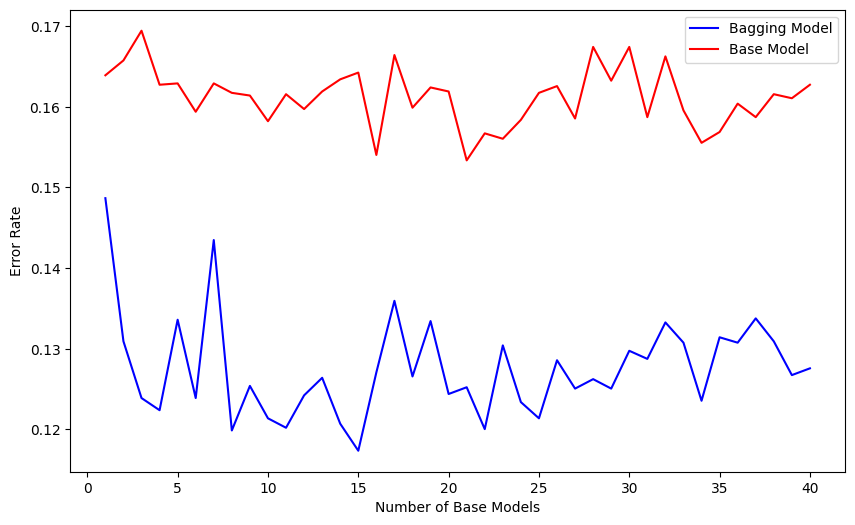

In [482]:
# 20
figure = plt.figure(figsize=(10, 6))

# Plot error rates
plt.plot(num_models, error_rates, c='b', label='Bagging Model')
plt.plot(num_models, base_error_rates, c='r', label='Base Model')
plt.xlabel('Number of Base Models')
plt.ylabel('Error Rate')
# plt.title('Error Rate vs. Number of Base Models in Bagging')
plt.legend(loc='upper right')
plt.show()


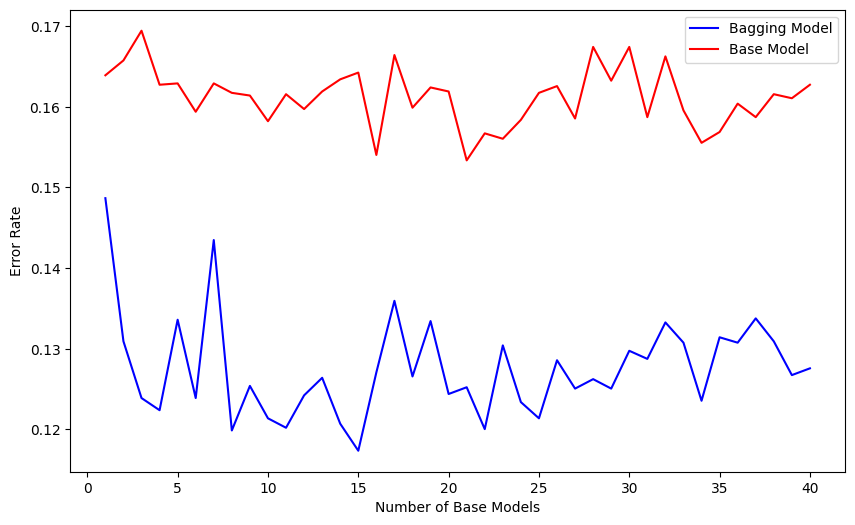

In [483]:
# 30
figure = plt.figure(figsize=(10, 6))

# Plot error rates
plt.plot(num_models, error_rates, c='b', label='Bagging Model')
plt.plot(num_models, base_error_rates, c='r', label='Base Model')
plt.xlabel('Number of Base Models')
plt.ylabel('Error Rate')
plt.legend(loc='upper right')
plt.show()

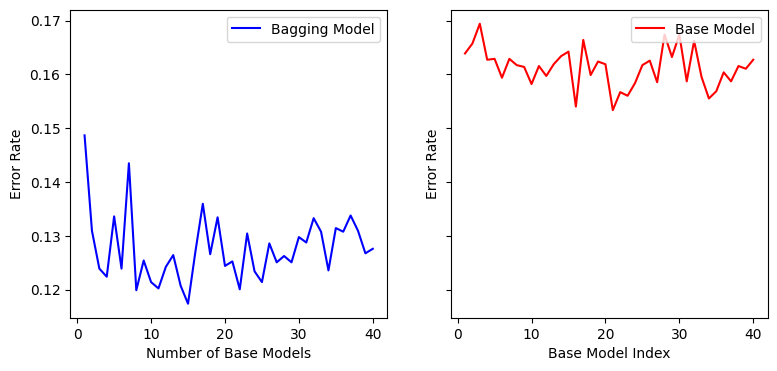

In [484]:
# 40
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)

ax1.plot(num_models, error_rates, c='b', label='Bagging Model')

# Plot error rates
ax1.set_xlabel('Number of Base Models')
ax1.set_ylabel('Error Rate')
ax1.legend(loc='upper right')

# Plot error rates
ax2.plot(num_models, base_error_rates, c='r', label='Base Model')
ax2.set_xlabel('Base Model Index')
ax2.set_ylabel('Error Rate')
# plt.title('Error Rate vs. Number of Base Models in Bagging')
ax2.legend(loc='upper right')

In [344]:
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import BaggingClassifier


error_rates_params=[]
# num_models = range(1, 21)
models_ranges = [range(1, i) for i in range(20, 60, 10)]
print(models_ranges)

for i in range(len(models_ranges)): 
    error_rates = []
    print(error_rates)
    for n_models in models_ranges[i]:
            bagging_clf = BaggingClassifier(
                base_estimator=DecisionTreeClassifier(),
                n_estimators=n_models,
                random_state=42
            ).fit(X_tr, y_tr)

            y_pred = bagging_clf.predict(X_test)
            error_rate = zero_one_loss(y_test, y_pred)
            error_rates.append(error_rate)
    error_rates_params.append(error_rates)

print(error_rates_params)

[range(1, 20), range(1, 30), range(1, 40), range(1, 50)]
[]


c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning:

[]


c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning:

[]


c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning:

[]


c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning:

[[0.16306713544282603, 0.12623472291980575, 0.13510798593671525, 0.1265695630336514, 0.13343378536748707, 0.12723924326134273, 0.1312573246274904, 0.1294157040013394, 0.12606730286288292, 0.12606730286288292, 0.12807634354595676, 0.1252302025782689, 0.12623472291980575, 0.1258998828059602, 0.12690440314749707, 0.12857860371672525, 0.12774150343211121, 0.12774150343211121, 0.12991796417210777], [0.16306713544282603, 0.12623472291980575, 0.13510798593671525, 0.1265695630336514, 0.13343378536748707, 0.12723924326134273, 0.1312573246274904, 0.1294157040013394, 0.12606730286288292, 0.12606730286288292, 0.12807634354595676, 0.1252302025782689, 0.12623472291980575, 0.1258998828059602, 0.12690440314749707, 0.12857860371672525, 0.12774150343211121, 0.12774150343211121, 0.12991796417210777, 0.12606730286288292, 0.12606730286288292, 0.12355600200904071, 0.12924828394441656, 0.12740666331826556, 0.12723924326134273, 0.12439310229365474, 0.1282437636028796, 0.12539762263519172, 0.12606730286288292]

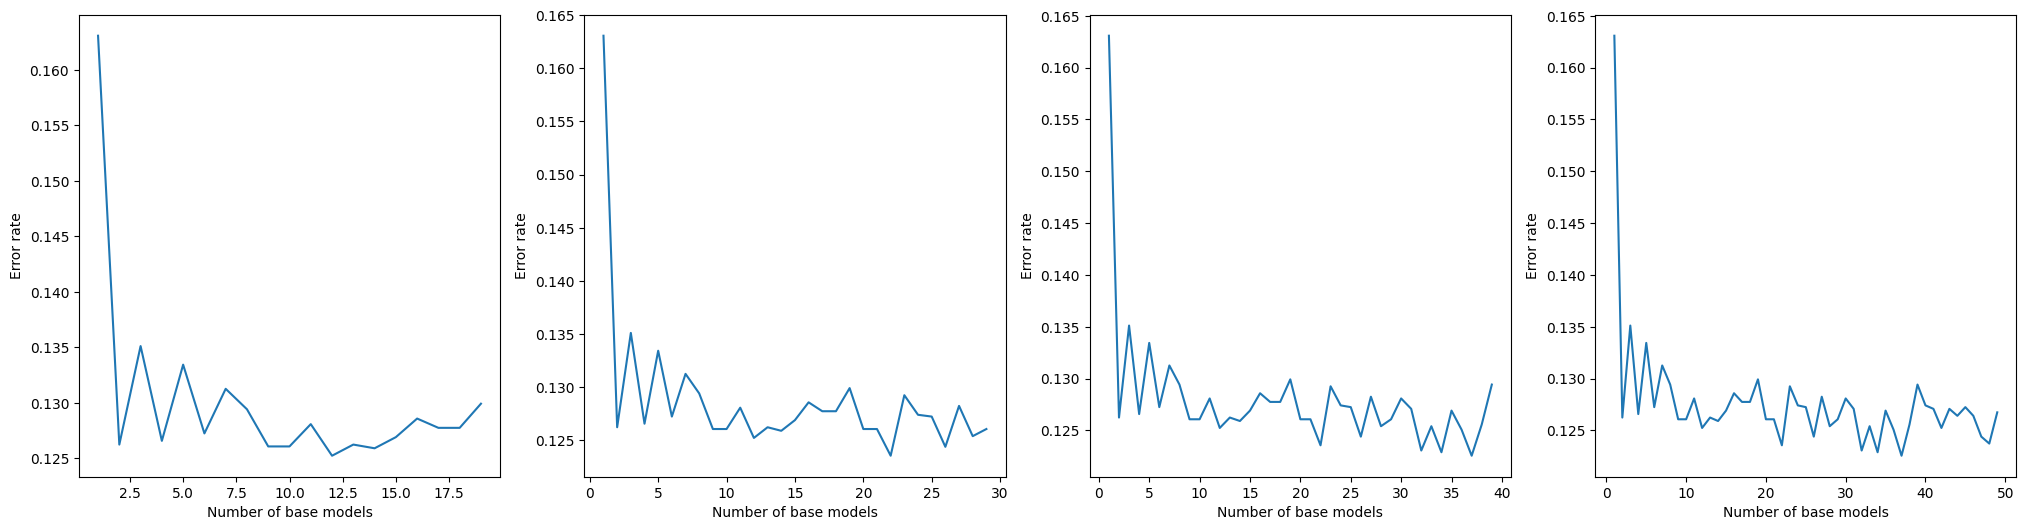

In [345]:
figure = plt.figure(figsize=(25, 6))
for i, error in enumerate(error_rates_params):
    
    ax = plt.subplot(1, len(error_rates_params), i+1)
    
    ax.plot(models_ranges[i], error_rates_params[i], label="error rate")
    ax.set_xlabel(f"Number of base models")
    ax.set_ylabel('Error rate')

In [347]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_depth' : (1,5,10,15,20,25)
              , 'criterion' : ('gini', 'entropy')
              , 'max_features' : ('auto', 'sqrt', 'log2')
              , 'min_samples_split' : (2,4,6)
             }

In [359]:
tree_cv = RandomizedSearchCV(DecisionTreeClassifier(), parameters, cv=5)
tree_cv.fit(X_tr, y_tr)

c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ('gini', 'entropy'),
                                        'max_depth': (1, 5, 10, 15, 20, 25),
                                        'max_features': ('auto', 'sqrt',
                                                         'log2'),
                                        'min_samples_split': (2, 4, 6)})

In [360]:
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best Decision Tree estimator: {}".format(tree_cv.best_estimator_))

Tuned Decision Tree Parameters: {'min_samples_split': 6, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy'}
Best Decision Tree estimator: DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_split=6)


In [434]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_tr, y_tr)
print(model.tree_.max_depth)
print("Accuracy on training set: {:.3f}".format(model.score(X_tr, y_tr)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

28
Accuracy on training set: 1.000
Accuracy on test set: 0.841


In [419]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=3,random_state=42)
model.fit(X_tr, y_tr)
print(model.tree_.max_depth)
print("Accuracy on training set: {:.3f}".format(model.score(X_tr, y_tr)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

3
Accuracy on training set: 0.896
Accuracy on test set: 0.837


In [491]:
model = BaggingClassifier(
                base_estimator=DecisionTreeClassifier(),
                random_state=42
            ).fit(X_tr, y_tr)
            
print("Accuracy on training set: {:.3f}".format(model.score(X_tr, y_tr)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy on training set: 0.998
Accuracy on test set: 0.874


In [435]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_leaf_nodes=30,random_state=42)
model.fit(X_tr, y_tr)
print(model.tree_.max_depth)
print("Accuracy on training set: {:.3f}".format(model.score(X_tr, y_tr)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

12
Accuracy on training set: 0.930
Accuracy on test set: 0.866


In [456]:
print(train_accuracy)
print(test_accuracy)

[0.9858737018641553, 0.9857661957900621, 0.9941516695693307, 0.9933991270506783, 0.9965813068438367, 0.9960007740437334, 0.9974628566514008, 0.9974628566514008, 0.9985164161775141, 0.9983229052441462, 0.998817433184975, 0.9987529295405191, 0.9991184501924358, 0.9992259562665291, 0.999290459910985, 0.9993549635554408, 0.9994409684147154, 0.9994839708443527, 0.9995699757036273, 0.9995914769184459]
[0.8598694123556002, 0.8987108655616943, 0.8737652770801942, 0.893353423740164, 0.8826385400971036, 0.8921814833417043, 0.8828059601540265, 0.8953624644232379, 0.8946927841955467, 0.8972040850493889, 0.8983760254478487, 0.9022266867570735, 0.9020592667001507, 0.9042357274401474, 0.9049054076678386, 0.9039008873263017, 0.9040683073832245, 0.9052402477816842, 0.908253808806295, 0.9099280093755232]


In [604]:
feature_sample_size = 200
max_depth_values = range(1, 21)
criterion = ['gini', 'entropy', 'log_loss']
splitter = ['best', 'random']
min_samples_split = range(2, 20)
# min_samples_leaf = defaut=1
max_features = ['sqrt', 'log2']
min_impurity_decrease = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]


The Training Accuracy for max_depth 1 is: 0.8750349394740803
The Testing Accuracy for max_depth 1 is: 0.9052402477816842

The Training Accuracy for max_depth 2 is: 0.89223591132899
The Testing Accuracy for max_depth 2 is: 0.9198057927339696

The Training Accuracy for max_depth 3 is: 0.896385645788987
The Testing Accuracy for max_depth 3 is: 0.836932864557174

The Training Accuracy for max_depth 4 is: 0.9104474402803758
The Testing Accuracy for max_depth 4 is: 0.9121044701155199

The Training Accuracy for max_depth 5 is: 0.9211765464748758
The Testing Accuracy for max_depth 5 is: 0.9129415704001339

The Training Accuracy for max_depth 6 is: 0.9247672493495882
The Testing Accuracy for max_depth 6 is: 0.908253808806295

The Training Accuracy for max_depth 7 is: 0.9292180008170462
The Testing Accuracy for max_depth 7 is: 0.8781181985601875

The Training Accuracy for max_depth 8 is: 0.9337117547141414
The Testing Accuracy for max_depth 8 is: 0.8908421228863218

The Training Accuracy for max

c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning:

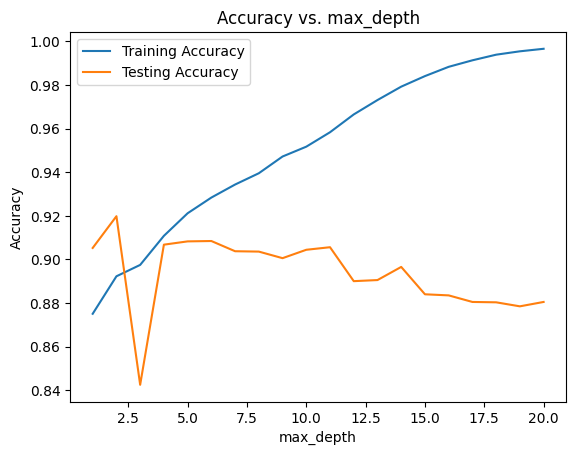

In [606]:
max_depth_values = range(1, 21)

for max_d in max_depth_values:
  model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
  model.fit(X_tr, y_tr)
  print('The Training Accuracy for max_depth {} is:'.format(max_d), model.score(X_tr, y_tr))
  print('The Testing Accuracy for max_depth {} is:'.format(max_d), model.score(X_test,y_test))
  print('')


import matplotlib.pyplot as plt

train_accuracy = []
test_accuracy = []

for max_d in max_depth_values:
    model = BaggingClassifier(
                base_estimator=DecisionTreeClassifier(
                  max_depth=max_d,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))

plt.plot(max_depth_values, train_accuracy, label='Training Accuracy')
plt.plot(max_depth_values, test_accuracy, label='Testing Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. max_depth')
plt.legend()
plt.show()

c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


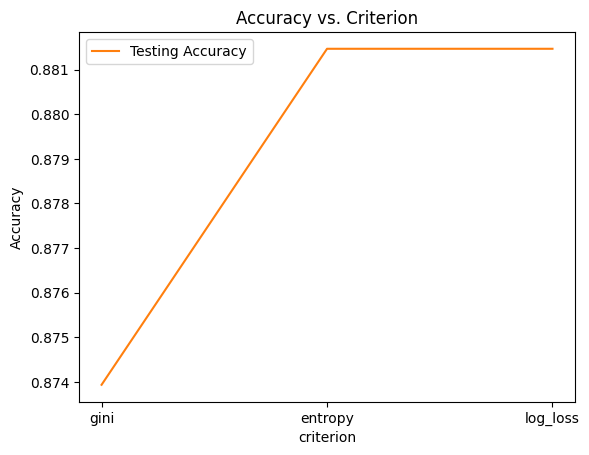

In [587]:
import matplotlib.pyplot as plt

train_accuracy = []
test_accuracy = []

for c in criterion:
    model = BaggingClassifier(
                base_estimator=DecisionTreeClassifier(
                  criterion=c,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))

# plt.plot(criterion, train_accuracy, label='Training Accuracy')
plt.plot(criterion, test_accuracy, label='Testing Accuracy', c='tab:orange')
plt.xlabel('criterion')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Criterion')
plt.legend()
plt.show()

c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


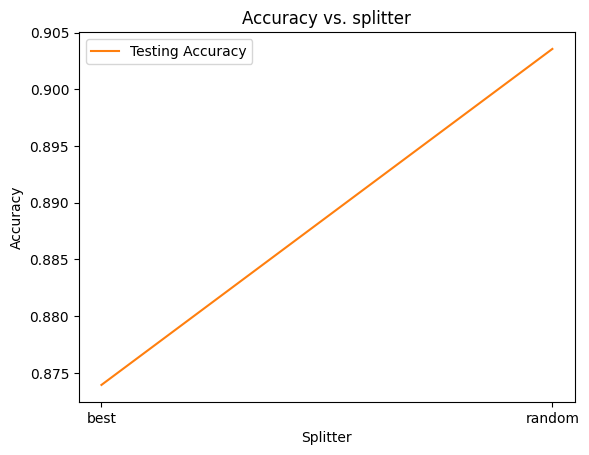

In [586]:
import matplotlib.pyplot as plt

train_accuracy = []
test_accuracy = []

for s in splitter:
    model = BaggingClassifier(
                base_estimator=DecisionTreeClassifier(
                  splitter=s,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))

# plt.plot(splitter, train_accuracy, label='Training Accuracy')
plt.plot(splitter, test_accuracy, label='Testing Accuracy', c='tab:orange')
plt.xlabel('Splitter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. splitter')
plt.legend()
plt.show()

c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning:

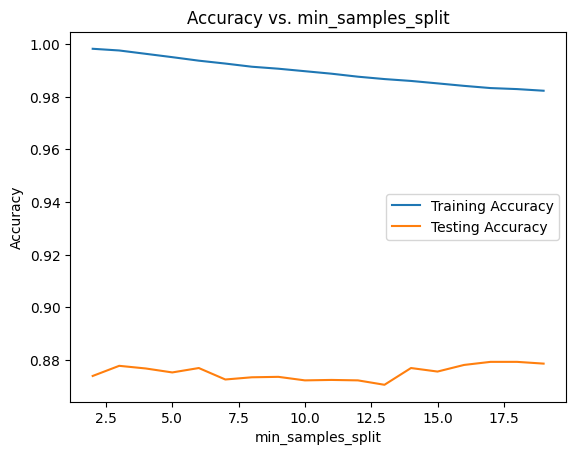

In [551]:
import matplotlib.pyplot as plt

train_accuracy = []
test_accuracy = []

for mss in min_samples_split:
    model = BaggingClassifier(
                base_estimator=DecisionTreeClassifier(
                  min_samples_split=mss,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))
  
plt.plot(min_samples_split, train_accuracy, label='Training Accuracy')
plt.plot(min_samples_split, test_accuracy, label='Testing Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. min_samples_split')
plt.legend()
plt.show()

c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


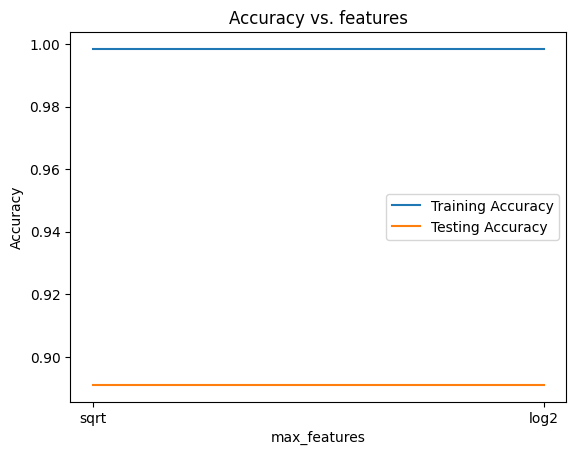

In [605]:
import matplotlib.pyplot as plt

train_accuracy = []
test_accuracy = []

for f in max_features:
    model = BaggingClassifier(
                base_estimator=DecisionTreeClassifier(
                  max_features=f,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))
  
plt.plot(max_features, train_accuracy, label='Training Accuracy')
plt.plot(max_features, test_accuracy, label='Testing Accuracy')
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. features')
plt.legend()
plt.show()

c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning:

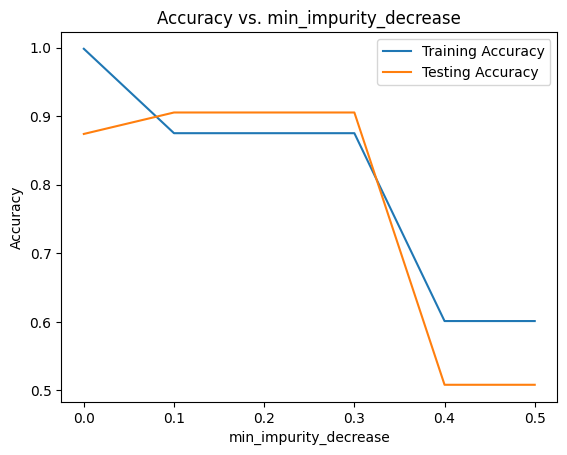

In [585]:
import matplotlib.pyplot as plt

train_accuracy = []
test_accuracy = []

for impurity in min_impurity_decrease:
    model = BaggingClassifier(
                base_estimator=DecisionTreeClassifier(
                  min_impurity_decrease=impurity,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))
  
plt.plot(min_impurity_decrease, train_accuracy, label='Training Accuracy')
plt.plot(min_impurity_decrease, test_accuracy, label='Testing Accuracy')
plt.xlabel('min_impurity_decrease')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. min_impurity_decrease')
plt.legend()
plt.show()

In [498]:
bagging_clf = BaggingClassifier(
        base_estimator=DecisionTreeClassifier(),
        random_state=42
    ).fit(X_tr, y_tr)
print("Test set accuracy: {}".format(accuracy))


c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test set accuracy: 0.8982086053909258


In [520]:
param_dist = {
    "max_depth": [3, 5, 10, None], 
    "max_features":  [3, 5, 10, "auto", "sqrt", "log2"],
    "min_samples_split": [2, 4, 6], 
    "criterion": ["gini", "entropy"]
    "max_leaf_nodes": []
    } 

model = DecisionTreeClassifier()
model_cv = RandomizedSearchCV(model, param_dist, n_iter=10, cv=5, verbose=2, n_jobs=-1)


In [521]:
model_cv.fit(X_tr, y_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, None],
                                        'max_features': [3, 5, 10, 'auto',
                                                         'sqrt', 'log2'],
                                        'min_samples_split': [2, 4, 6]},
                   verbose=2)

In [522]:
print("Tuned Decision Tree Parameters: {}".format(model_cv.best_params_))
print("Best score is {}".format(model_cv.best_score_))

Tuned Decision Tree Parameters: {'min_samples_split': 4, 'max_features': 5, 'max_depth': 10, 'criterion': 'gini'}
Best score is 0.9009653054231481
